<a href="https://colab.research.google.com/github/Dunckleosteus/Peroskite/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import os
try:
  import wget
except:
  !pip install wget
  import wget

In [2]:
path_to_file = "Crystal_structure.csv"
if os.path.exists(path_to_file):
    df = pd.read_csv(path_to_file)
else:
    os.remove("/content/Crystal_structure.csv")
    wget.url("https://raw.githubusercontent.com/Dunckleosteus/Peroskite/refs/heads/main/Crystal_structure.csv")
    df = pd.read_csv("/content/Crystal_structure.csv")

df.describe()

,r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,μ
count,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000
mean,0.974656,0.825617,0.817845,1.572466,1.572466,2.289800,2.012587,-2.199993,0.766090,0.584176
std,0.337139,0.245000,0.247480,0.449248,0.449248,0.664239,0.598509,0.668465,0.136280,0.176770
min,0.270000,0.270000,0.270000,0.790000,0.790000,0.000000,0.000000,-5.411536,0.384648,0.192857
25%,0.690000,0.630000,0.630000,1.200000,1.200000,2.290644,1.956808,-2.604821,0.668537,0.450000
50%,0.930000,0.800000,0.770000,1.550000,1.550000,2.393444,2.096141,-2.101179,0.756440,0.550000
75%,1.180000,0.950000,0.950000,1.930000,1.930000,2.571812,2.286435,-1.711500,0.850628,0.678571
max,1.880000,1.670000,1.670000,2.540000,2.540000,3.300176,3.009747,-0.601714,1.388809,1.192857


In [3]:
for col in df.columns:
    print(col)

Compound
A
B
In literature
v(A)
v(B)
r(AXII)(Å)
r(AVI)(Å)
r(BVI)(Å)
EN(A)
EN(B)
l(A-O)(Å)
l(B-O)(Å)
ΔENR
tG
τ
μ
Lowest distortion


# Data
The element we are are trying to estimate in our dataset is lowest distortion. This is our label. Now we need to identify the rows where these label is missing, for the lines that do have this label, it must be split into test and traind dataset.
## Columns

In [4]:
df.dtypes

,0
Compound,object
A,object
B,object
In literature,bool
v(A),object
v(B),object
r(AXII)(Å),float64
r(AVI)(Å),float64
r(BVI)(Å),float64
EN(A),float64


As we can see only some of the columns are numbers. These are:
```
["r(AXII)(Å)", "r(AVI)(Å)", "r(BVI)(Å)", "EN(A)", "EN(B)", "l(A-O)(Å)", "l(B-O)(Å)", "ΔENR", "tG", "μ"]
```

## Missing values

In [5]:
print("Intial df length: {}".format(len(df.index)))
print("Len df after dropna: {}".format(len(df.dropna(subset="Lowest distortion", inplace=False).index)))

Intial df length: 5329
Len df after dropna: 5329


We can see that the length of the dataframe does not change after removing nan, hence all the rows have data. Upon closer inspection we can see that the some of the labels are replaced by "-".

In [6]:
print(len(df.loc[df["Lowest distortion"] == '-', :]))
df_subset = df.loc[df["Lowest distortion"] != '-', :].copy()

53


We can see that 53 values are missing. We create a subset based on this observation.

# Quality control
## Missing values
Now that we have identified the columns that are numeric, now we check to see how many values are missing.

In [7]:
numeric_cols = ["r(AXII)(Å)", "r(AVI)(Å)", "r(BVI)(Å)", "EN(A)", "EN(B)", "l(A-O)(Å)", "l(B-O)(Å)", "ΔENR", "tG", "μ"]
start_len = len(df.index)
for col in numeric_cols:
    print("{}: {}-{} = {} missing values".format(col, start_len, len(df.dropna(subset=col, inplace=False)), start_len - len(df.dropna(subset=col, inplace=False))))

r(AXII)(Å): 5329-5329 = 0 missing values
r(AVI)(Å): 5329-5329 = 0 missing values
r(BVI)(Å): 5329-5329 = 0 missing values
EN(A): 5329-5329 = 0 missing values
EN(B): 5329-5329 = 0 missing values
l(A-O)(Å): 5329-5329 = 0 missing values
l(B-O)(Å): 5329-5329 = 0 missing values
ΔENR: 5329-5329 = 0 missing values
tG: 5329-5329 = 0 missing values
μ: 5329-5329 = 0 missing values


None of them seen to have any missing values.

# Basic ML workflow

Number of mislabeled points out of a total 2638 points : 1111


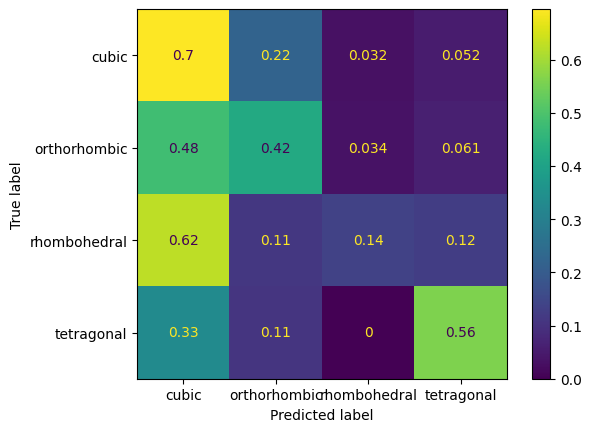

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X, y = df_subset[numeric_cols], df_subset["Lowest distortion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()

# Permutation
Test all the possible permutations and re-run the same model to see which one has the best result.

In [9]:
number_of_columns_in_model = 2
minimum = 100
for comb in combinations(numeric_cols, number_of_columns_in_model):
    X, y = df_subset[[x for x in comb]], df_subset["Lowest distortion"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)

    error = round((y_test != y_pred).sum() / X_test.shape[0]*100, 2)
    minimum = error if error < minimum else minimum
    print("columns {} -> {} % of errors".format(comb, error))

print(minimum)

columns ('r(AXII)(Å)', 'r(AVI)(Å)') -> 36.62 % of errors
columns ('r(AXII)(Å)', 'r(BVI)(Å)') -> 37.87 % of errors
columns ('r(AXII)(Å)', 'EN(A)') -> 38.17 % of errors
columns ('r(AXII)(Å)', 'EN(B)') -> 38.21 % of errors
columns ('r(AXII)(Å)', 'l(A-O)(Å)') -> 37.19 % of errors
columns ('r(AXII)(Å)', 'l(B-O)(Å)') -> 39.61 % of errors
columns ('r(AXII)(Å)', 'ΔENR') -> 39.88 % of errors
columns ('r(AXII)(Å)', 'tG') -> 34.8 % of errors
columns ('r(AXII)(Å)', 'μ') -> 37.87 % of errors
columns ('r(AVI)(Å)', 'r(BVI)(Å)') -> 37.19 % of errors
columns ('r(AVI)(Å)', 'EN(A)') -> 36.69 % of errors
columns ('r(AVI)(Å)', 'EN(B)') -> 38.32 % of errors
columns ('r(AVI)(Å)', 'l(A-O)(Å)') -> 39.08 % of errors
columns ('r(AVI)(Å)', 'l(B-O)(Å)') -> 40.14 % of errors
columns ('r(AVI)(Å)', 'ΔENR') -> 40.41 % of errors
columns ('r(AVI)(Å)', 'tG') -> 34.84 % of errors
columns ('r(AVI)(Å)', 'μ') -> 37.19 % of errors
columns ('r(BVI)(Å)', 'EN(A)') -> 37.6 % of errors
columns ('r(BVI)(Å)', 'EN(B)') -> 36.05 % of 

In [10]:
df.groupby("Lowest distortion").count()

,Compound,A,B,In literature,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ
Lowest distortion,,,,,,,,,,,,,,,,,
-,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
cubic,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253
orthorhombic,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573,1573
rhombohedral,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323
tetragonal,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127


# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X, y = df_subset[numeric_cols], df_subset["Lowest distortion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

param_grid = {
    "n_estimators":[100, 200, 300],
    "max_depth":[None, 5, 10, 15],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf":[1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
best_params = grid_search.best_params_
best_model_all_params = grid_search.best_estimator_
y_pred = best_model_all_params.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# generate classification report
target_names = sorted(df_subset["Lowest distortion"].unique())
report = classification_report(y_test, y_pred, target_names = target_names)
print(report)

# create confusion report
cm = confusion_matrix(y_test, y_pred, labels=target_names, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()

In [ ]:
feature_importances = best_model_all_params.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature":X_train.columns,
    "Importance":feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
fig, ax = plt.subplots()
ax.barh(feature_importance_df.Feature, feature_importance_df.Importance)

## Running with less parameters
From the plot above we can see that the most important parameters in the random forest model seems to be DeltaENR and tG, we are going to do the same approach wiht only these 2 columns.

In [ ]:
df_subset.columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X, y = df_subset[["tG", "ΔENR"]], df_subset["Lowest distortion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

param_grid = {
    "n_estimators":[100, 200, 300],
    "max_depth":[None, 5, 10, 15],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf":[1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)
# performance of model
best_params = grid_search.best_params_
best_model  = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# generate classification report
target_names = sorted(df_subset["Lowest distortion"].unique())
report = classification_report(y_test, y_pred, target_names = target_names)
print(report)

# create confusion report
cm = confusion_matrix(y_test, y_pred, labels=target_names, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()

# Propagating the model to unknown values

In [ ]:
df_unknown = df.loc[df["Lowest distortion"]=="-", numeric_cols]

df_unknown.columns == df_subset[numeric_cols].columns
y_pred = best_model_all_params.predict(df_unknown)
df_unknown["predicted"] = y_pred
df_unknown